In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
# requirements

# pandas==1.3.5
# numpy==1.22.4
# scikit-learn==1.2.1
# cleanlab==2.3.1
# transformers==4.27.4
# spacy==3.5.1
# catboost==1.1.1
# tensorflow_text==2.12.0
# matplotlib==3.7.1
# tensorflow==2.12.0
# re==2.2.1
# nltk==3.8.1
# tqdm==4.65.0
# torch==2.0.0+cu118
# tensorflow-hub==0.13.0

In [ ]:
!pip install cleanlab==2.3.1 -q
!pip install scikit-learn==1.2.1 -q
!pip install transformers==4.27.4 -q
!pip install spacy==3.5.1 -q
!spacy download en
!pip install catboost==1.1.1 -q
!pip install tensorflow_text==2.12.0 -q

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 


import sklearn
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from cleanlab.filter import find_label_issues


import re 
import pickle
import spacy
import string

import nltk
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

from tqdm import tqdm, notebook

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The numpy version is {}.'.format(np.__version__))

The scikit-learn version is 1.2.1.
The pandas version is 1.3.5.
The numpy version is 1.22.4.


In [ ]:
# Set constants
PATH = '/content/drive/MyDrive/MachineHack: Data Centric AI Competition 2023'
RANDOM_SEED = 0

In [ ]:
tqdm.pandas()
pd.set_option('max_colwidth', None)

tf.random.set_seed(RANDOM_SEED)

In [ ]:
# Load BERT-Pretrained
def load_bert(output_hidden_states=False):
    tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
    model = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis", output_hidden_states=output_hidden_states)
    return tokenizer, model

# Helper to convert given labels to 0-indexed (necessary for cleanlab and various ML processes).
def labels_to_zeroidx(labels):
    unique_labels = set(labels)
    label2idx = dict(zip(unique_labels, range(len(unique_labels))))
    return [label2idx[label] for label in labels]

# Save object to pickle
def save_to_pkl(object, file_name):
    with open(f"{PATH}/{file_name}", 'wb') as f:
        pickle.dump(object, f)
    print(f"Successfully safed to {file_name}")

# Load object from pickle
def load_from_pkl(file_name):
    with open(f"{PATH}/{file_name}", 'rb') as f:
        obj = pickle.load(f)
    return obj

# Data

In [ ]:
# Read in train and test data.
# train_df = pd.read_csv(f'{PATH}/train.csv')
train_df = pd.read_csv(f'{PATH}/train_df.csv')
test_data = pd.read_csv(f'{PATH}/validation.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12652 entries, 0 to 12651
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    12652 non-null  int64 
 1   review_text  12652 non-null  object
 2   label        12652 non-null  int64 
 3   words_only   12652 non-null  object
 4   lemmas       12652 non-null  object
 5   words_count  12652 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 593.2+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    500 non-null    int64 
 1   review_text  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
train_df.sample(5)

,review_id,review_text,label,words_only,lemmas,words_count
6231,83486,An excellent publication. The only literary/book review that I read from cover to cover. It has lead me to several wonderful books.,5,An excellent publication The only literary book review that I read from cover to cover It has lead me to several wonderful books,an excellent publication the only literary review that i read from cover to cover it have lead i to several wonderful book,23
11360,53006,"Very Unprofessional and unintelligent articles, with terrible layout display!",1,Very Unprofessional and unintelligent articles with terrible layout display,very unprofessional and unintelligent article with terrible layout display,9
11578,54603,There are no channel #'s next to the programs and the programs start at 6 or 7 pm. I am very dissapointed with the TV Guide and won't re-order it.,1,There are no channel s next to the programs and the programs start at or pm I am very dissapointed with the TV Guide and won t re order it,there be no channel be next to the program and the program start at 6 or 7 pm i be very dissapointe with the tv guide and will not re it,30
11387,53245,What can I say? One of the best decorating mags around.,5,What can I say One of the best decorating mags around,what can i say one of the well decorate mag around,11
1302,36382,"I did not agree to auto renewal, and when made aware of the gimmick, it was very difficult to undo. Dumb policy and bad process.",1,I did not agree to auto renewal and when made aware of the gimmick it was very difficult to undo Dumb policy and bad process,i do not agree to auto renewal and when make aware of the gimmick it be very difficult to undo dumb policy and bad process,25


In [ ]:
# Count duplicates
train_df['review_id'].duplicated().sum()

0

In [ ]:
# Count unique labels
train_df['label'].value_counts().sort_index()

1    3440
2    1274
3    1873
4    1994
5    4071
Name: label, dtype: int64

# Data Preprocessing and Feature Engeneering

In [ ]:
# Extract omly words from reviews
def extract_words(string):
    string_of_words = ' '.join(re.findall(r'[A-Za-z]+', string))
    return string_of_words

# Import the "string" library again, otherwise the error appears, download spacy model
nlp = spacy.load('en_core_web_sm',  disable=['parser', 'ner'])
import string

# Tokenization and lemmatization of the text, and then again combining the words into a single line
def tokenize_lemmatize(text, nlp=nlp):
  list_of_tokens = list()

  for token in nltk.word_tokenize(text):
    if (token in string.punctuation) or (token == '...'): 
      continue
    if '\'' in token: 
      token = re.sub('\'ve', 'have', token)
      token = re.sub('\'m|\'s|\'re', 'be', token)
      token = re.sub('n\'t', 'not', token)
      token = re.sub('\'d', 'would', token)
    if token == '\'':
      token = re.sub('\'', '', token)
    if token == 'ca':
      token = re.sub('ca', 'can', token)
    doc = nlp(token) # Лемматизация токена (шаг 1)
    token = [tok.lemma_ for tok in doc][0] # Лемматизация токена (шаг 2)
    # Приводим к одному регистру
    if token != '-PRON-':
      token = token.lower()
    list_of_tokens.append(token)
  one_string = ' '.join(list_of_tokens)
  return one_string

Thoughts  
*Save the capslocks - it is possible, but everything else should be in small letters.*  
*Punctuation, exclamation marks, etc. - can play a role.*   
*Words written with grammatical errors will be taken into account.*  

*We can sacrifice punctuation marks and words with punctuation marks.  
Leave numbers and words in singular form.*

In [ ]:
train_df['words_only'] = train_df['review_text'].apply(extract_words)
train_df['lemmas'] = train_df['review_text'].progress_apply(lambda x: tokenize_lemmatize(x))
train_df['words_count'] = train_df['words_only'].str.split(' ').apply(lambda x: len(x))

In [ ]:
# Count mean number of words in each class
train_df.groupby('label').words_count.median()

label
1    19.0
2    18.0
3    18.0
4    17.0
5    16.0
Name: words_count, dtype: float64

5 Star


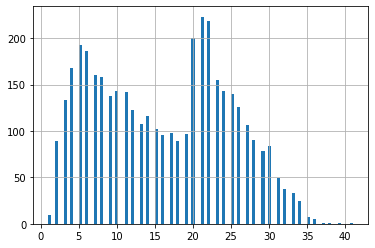

4 Star


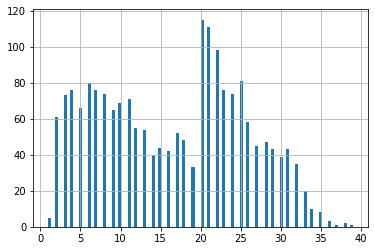

1 Star


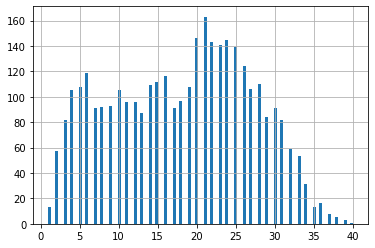

2 Star


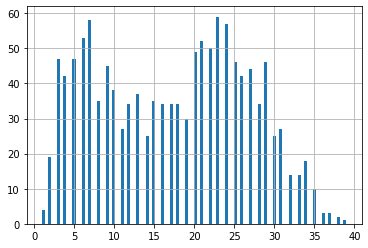

3 Star


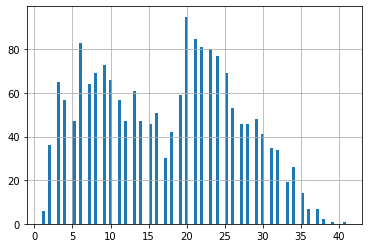

In [ ]:
# Plot distribution of number of words in each class
for lbl in train_df.label.unique():
    print(lbl, "Star")
    plt.hist(train_df[train_df['label'] == lbl]['words_count'], bins=100)
    plt.grid()
    plt.show()

In [ ]:
# Save new train data into csv
# train_df.to_csv(f'{PATH}/train_df.csv', index=False)
train_df.head()

,review_id,review_text,label,words_only,lemmas,words_count
0,57,I have been a Maximum PC reader since its beginning and still read it cover to cover. Awesome magazine. Love it,5,I have been a Maximum PC reader since its beginning and still read it cover to cover Awesome magazine Love it,i have be a maximum pc reader since its begin and still read it cover to cover awesome magazine love it,21
1,97,"If you into gaming, into the latest PC tech info, like reviews of hardware rated 1 thru 10, chomp PC builds, get this rag. @ $12 bucks for 2 years its worth every penny",5,If you into gaming into the latest PC tech info like reviews of hardware rated thru chomp PC builds get this rag bucks for years its worth every penny,if you into game into the late pc tech info like review of hardware rate 1 thru 10 chomp pc build get this rag 12 buck for 2 year its worth every penny,29
2,147,This is a great magazine.... Subscribed for many many years.,4,This is a great magazine Subscribed for many many years,this be a great magazine .... subscribe for many many year,10
3,148,sucks (period),1,sucks period,suck period,2
4,151,too many ads the whole magazine is ads. I cant believe real men dress like that. I just read the product reviews then throw magazines away don't want anyone to think i like guys.,2,too many ads the whole magazine is ads I cant believe real men dress like that I just read the product reviews then throw magazines away don t want anyone to think i like guys,too many ad the whole magazine be ad i can believe real man dress like that i just read the product review then throw magazine away do not want anyone to think i like guy,35


List of features:  
- `review_text`. Contains the original text of the review
- `words_only`. Words extracted from the original text `review_text`. Without numbers, symbols or punctuation marks.
- `lemmas`. Lemmas extracted from the original `review_text`. Contains words-lemmas and numbers, without punctuation symbols.
- `words_count`. Number of words in a sentence.

# TfIdfVectorizer

### WordsOnly + TfIdf + Linear Model

In [ ]:
# Training data.
train_X = train_df['words_only']
train_y = train_df['label']

train_X.shape, train_y.shape

((12652,), (12652,))

In [ ]:
# Without GridSearch
cross_val_score(Pipeline([('tfidf', TfidfVectorizer()), ('clf', SGDClassifier(loss="log_loss", penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True))]),
                          train_X, train_y).mean()

0.6847192207926065

In [ ]:
# First GridSearch

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()

model_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', classifier)])

param_grid = {
    "tfidf__max_df": [0.5, 0.8, 1.0],
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__loss": ["hinge", "log_loss"],
    "clf__alpha": [0.0001, 0.001, 0.01, 1, 10, 100], 
    "clf__l1_ratio": [0.2, 0.5, 0.8],
    "clf__class_weight": [None, "balanced"]
}

gcv = GridSearchCV(model_pipe, param_grid, scoring="accuracy", n_jobs=-1)

gcv.fit(train_X, train_y)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      penalty='elasticnet',
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__l1_ratio': [0.2, 0.5, 0.8],
                         'clf__loss': ['hinge', 'log_loss'],
                         'tfidf__max_df': [0.5, 0.8, 1.0],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy')

In [ ]:
print("Best params", gcv.best_params_)
print("Best score", gcv.best_score_)
print("Std", pd.DataFrame(gcv.cv_results_) .loc[gcv.best_index_, :].std_test_score)

with open(f'{PATH}/gcv.pkl', 'wb') as f:
    pickle.dump(gcv, f)

Best params {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.2, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Best score 0.6839288943581799
Std 0.040802945306573274


In [ ]:
# Second GridSearch
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()

model_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', classifier)])

param_grid1 = {
    "tfidf__max_df": [0.1, 0.3, 0.5], # Change max_df
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__loss": ["hinge", "log_loss"],
    "clf__l1_ratio": [0., 0.1, 0.2], # Change l1_ratio
    "clf__alpha": [1e-6, 1e-5, 1e-4], #Change alpha
    "clf__class_weight": [None, "balanced"]
}

gcv1 = GridSearchCV(model_pipe, param_grid1, scoring="accuracy", n_jobs=-1)

gcv1.fit(train_X, train_y)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      penalty='elasticnet',
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [1e-06, 1e-05, 0.0001],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__l1_ratio': [0.0, 0.1, 0.2],
                         'clf__loss': ['hinge', 'log_loss'],
                         'tfidf__max_df': [0.1, 0.3, 0.5],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy')

In [ ]:
print("Best params1", gcv1.best_params_)
print("Best score1", gcv1.best_score_)
print("Std1", pd.DataFrame(gcv1.cv_results_) .loc[gcv1.best_index_, :].std_test_score)

save_to_pkl(gcv1, 'gcv1.pkl')

Best params1 {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.1, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Best score1 0.6851144152430806
Std1 0.0405887110967916


In [ ]:
# submission_1_gcv1.csv
# 5-fold-cv = 0.68511
# public    = 0.75333

### Lemmas + TfIdf + Linear Model

In [ ]:
# Training data.
train_X = train_df['lemmas']
train_y = train_df['label']

train_X.shape, train_y.shape

((12652,), (12652,))

In [ ]:
# Without GridSearch
cross_val_score(Pipeline([('tfidf', TfidfVectorizer()), ('clf', SGDClassifier(loss="log_loss", penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True))]),
                          train_X, train_y).mean()

0.6738909303295265

In [ ]:
# First GridSearch
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()

model_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', classifier)])

param_grid1 = {
    "tfidf__max_df": [0.1, 0.3, 0.5],
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__loss": ["hinge", "log_loss"],
    "clf__l1_ratio": [0., 0.1, 0.2],
    "clf__alpha": [1e-6, 1e-5, 1e-4],
    "clf__class_weight": [None, "balanced"]
}

gcv2 = GridSearchCV(model_pipe, param_grid1, scoring="accuracy", n_jobs=-1, error_score="raise")

gcv2.fit(train_X, train_y)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      penalty='elasticnet',
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [1e-06, 1e-05, 0.0001],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__l1_ratio': [0.0, 0.1, 0.2],
                         'clf__loss': ['hinge', 'log_loss'],
                         'tfidf__max_df': [0.1, 0.3, 0.5],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy')

In [ ]:
print("Best params", gcv2.best_params_)
print("Best score", gcv2.best_score_)
print("Std", pd.DataFrame(gcv2.cv_results_) .loc[gcv2.best_index_, :].std_test_score)

save_to_pkl(gcv2, 'gcv2.pkl')

Best params {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.2, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Best score 0.6744441963135381
Std 0.03968458535524359
Successfully safed to gcv2.pkl


In [ ]:
# Second GridSearch
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()

model_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', classifier)])

param_grid2 = {
    "tfidf__max_df": [0.5, 0.6, 0.8], # Change max_df
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__loss": ["hinge", "log_loss"],
    "clf__l1_ratio": [0.2, 0.4, 0.7], # Change l1
    "clf__alpha": [1e-4, 1e-3, 1e-2], # Change alpha
    "clf__class_weight": [None, "balanced"]
}

gcv3 = GridSearchCV(model_pipe, param_grid2, scoring="accuracy", n_jobs=-1, error_score="raise")

gcv3.fit(train_X, train_y)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(early_stopping=True,
                                                      penalty='elasticnet',
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__l1_ratio': [0.2, 0.4, 0.7],
                         'clf__loss': ['hinge', 'log_loss'],
                         'tfidf__max_df': [0.5, 0.6, 0.8],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy')

In [ ]:
print("Best params", gcv3.best_params_)
print("Best score", gcv3.best_score_)
print("Std", pd.DataFrame(gcv3.cv_results_) .loc[gcv3.best_index_, :].std_test_score)

save_to_pkl(gcv3, 'gcv3.pkl')

Best params {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.2, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Best score 0.6744441963135381
Std 0.03968458535524359
Successfully safed to gcv3.pkl


In [ ]:
# submission_2_gcv3.csv
# 5-fold-cv = 0.67444
# public    = 0.76667

### Lemmas + TfIdf + BestSGDClassifier +  CleanlabLabels(model=BestSGDClassifier)

In [ ]:
# Training data.
train_X = train_df['lemmas']
train_y = train_df['label']

train_X.shape, train_y.shape

In [ ]:
best_params = {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.2, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5}

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()

model_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', classifier)])
model_pipe.set_params(**best_params)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5)),
                ('clf',
                 SGDClassifier(early_stopping=True, l1_ratio=0.2,
                               loss='log_loss', penalty='elasticnet',
                               random_state=0))])

In [ ]:
pred_probs = cross_val_predict(model_pipe, train_X, train_y, cv=10, method='predict_proba')

labels = labels_to_zeroidx(train_y)
issues_idx = find_label_issues(labels, pred_probs, return_indices_ranked_by='self_confidence')

# Show the top 5.
train_X.iloc[issues_idx][:5]

1015                                                   love it love it love it
7472     my favorite magazine love it chock full of great idea and information
8746             do not like the magazine not for i it have lot of advertising
2184         magazine be ok seem like the ad be more numerous than the article
11319             i love this magazine great info and i read it cover to cover
Name: lemmas, dtype: object

In [ ]:
# Drop all issues from training data.
train_X_clean = train_X.drop(issues_idx)
train_y_clean = train_y.drop(issues_idx)

for data in [train_X_clean, train_y_clean]:
    print(data.shape)

(9942,)
(9942,)


In [ ]:
cross_val_score(model_pipe, train_X_clean, train_y_clean, cv=10).mean()

0.8474194918253237

In [ ]:
test_data['lemmas'] = test_data['review_text'].apply(lambda x: tokenize_lemmatize(x))

# Re-train model on data with issues removed.
model_pipe.fit(train_X_clean, train_y_clean)
# Make predictions for submission.
test_preds = model_pipe.predict(test_data['lemmas'])

In [ ]:
# Submission_4.csv
# 10-fold-cv = 0.84741
# public    =  0.72667

### Lemmas + TfIdf + BestSGDClasssifer +  CleanlabLabels(model=BERT)

In [ ]:
# Training data.
train_X = train_df['lemmas']
train_y = train_df['label']

train_X.shape, train_y.shape

((12652,), (12652,))

In [ ]:
# Initialize pipeline with best TfIdfVectorizer and BestSGDClasssifer
best_params = {'clf__alpha': 0.0001, 'clf__class_weight': None, 'clf__l1_ratio': 0.2, 'clf__loss': 'log_loss', 'tfidf__max_df': 0.5}

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
tf = TfidfVectorizer()
model_pipe = Pipeline([('tfidf', tf), ('clf', classifier)])
model_pipe.set_params(**best_params)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5)),
                ('clf',
                 SGDClassifier(early_stopping=True, l1_ratio=0.2,
                               loss='log_loss', penalty='elasticnet',
                               random_state=0))])

In [ ]:
# Extract predicted probabilities from pretrained BERT model
tokenizer, model = load_bert(output_hidden_states=True)

inputs = train_df['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

pred_probs = logits.apply(lambda x: torch.nn.Softmax()(x).numpy())
pred_labels = logits.apply(lambda x: torch.nn.Softmax()(x).numpy().argmax() + 1)

t = pred_probs.apply(lambda x: x[0]).values
t1 = [[el[i] for i in range(len(el))] for el in t]
t2 = np.array(t1)

<ipython-input-31-e28a7cdd9fa9>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = logits.apply(lambda x: torch.nn.Softmax()(x).numpy())


In [ ]:
# Find issues indexes
labels = labels_to_zeroidx(train_y)
issues_idx = find_label_issues(labels, t2, return_indices_ranked_by='self_confidence')

# Show the top 5.
train_X.iloc[issues_idx][:5]

2704     love this magazine the well gf magazine i have see by far informative article and product info super recipe beautiful photo and easy to read layout
12546                                       love all the tip and new thing to fix enjoy learn how the star cook and do thing all the recipe will keep i busy
8441                                           my grandkid love this they can not wait to read it and learn ton of stuff wonderful to teach the love of read
11080                                                               my favorite magazine i love everything pop culture and entertainment weekly cover it all
2004                                     great book will continue to get it the well satire magazine ever write great service for a continue great time read
Name: lemmas, dtype: object

In [ ]:
train_df.iloc[issues_idx][:5]

,review_id,review_text,label,words_only,lemmas,words_count
2704,69059,"Love this magazine - the best GF magazine I have seen by far. Informative articles and product info, super recipes, beautiful photos, and easy to read layout.",1,Love this magazine the best GF magazine I have seen by far Informative articles and product info super recipes beautiful photos and easy to read layout,love this magazine the well gf magazine i have see by far informative article and product info super recipe beautiful photo and easy to read layout,26
12546,64044,Love all the tips and new things to fix. Enjoy learning how the stars cook and do things. All the recipes will keep me busy :),1,Love all the tips and new things to fix Enjoy learning how the stars cook and do things All the recipes will keep me busy,love all the tip and new thing to fix enjoy learn how the star cook and do thing all the recipe will keep i busy,25
8441,28683,"My grandkids love this. They can't wait to read it, and learn tons of stuff. Wonderful to teach the love of reading!",1,My grandkids love this They can t wait to read it and learn tons of stuff Wonderful to teach the love of reading,my grandkid love this they can not wait to read it and learn ton of stuff wonderful to teach the love of read,23
11080,50833,My favorite magazine! I love everything pop culture and entertainment weekly covers it all.,1,My favorite magazine I love everything pop culture and entertainment weekly covers it all,my favorite magazine i love everything pop culture and entertainment weekly cover it all,14
2004,66261,Great book. Will continue to get it!!!!!!! The best satire magazine ever written. Great service for a continued great time reading.,1,Great book Will continue to get it The best satire magazine ever written Great service for a continued great time reading,great book will continue to get it the well satire magazine ever write great service for a continue great time read,21


In [ ]:
# Drop all issues from training data.
train_X_clean = train_X.drop(issues_idx)
train_y_clean = train_y.drop(issues_idx)

for data in [train_X_clean, train_y_clean]:
    print(data.shape)

(9791,)
(9791,)


In [ ]:
print("Accuracy of predicted by BERT labels excluding issue_idx:", accuracy_score(train_y.drop(issues_idx), pred_labels.drop(issues_idx)))

Accuracy of predicted by BERT labels excluding issue_idx: 0.7972627923603309


In [ ]:
print("10-fold CV on clean dataset:", cross_val_score(model_pipe, train_X_clean, train_y_clean, cv=10).mean())

10-fold CV on clean dataset: 0.8002340997686102


In [ ]:
# Create lemmas feature for test data
test_data['lemmas'] = test_data['review_text'].apply(lambda x: tokenize_lemmatize(x))

# Re-train model on data with issues removed.
model_pipe.fit(train_X_clean, train_y_clean)

# Make predictions for submission.
test_preds = model_pipe.predict(test_data['lemmas'])

In [ ]:
# save_to_pkl(issues_idx, "issue_idx_by_bert.pkl")

Successfully safed to issue_idx_by_bert.pkl


In [ ]:
# Submission_5
# 10-fold-cv = 0.80023
# public    =  0.77333

**Resume**.  
The error indices that were found using BERT's model can be considered the most accurate, as the logistic regression trained on the purified sample was able to show the result of public test 0.77333. 

This sample can be used to train other models.

# Embeddings

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-large/1")

def embed(input):
  return use(input)

def embed_large(input):
  return use_large(input)

def embed_bert(input_data):
    """
    Input - pd.Series
    Output - np.array
    """
    data = input_data.copy()
    batch_size = 100
    embeddings = []
    data_shape = data.shape[0]

    for i in notebook.tqdm(range(data_shape // batch_size + 1)):
        with tf.device('/device:GPU:0'):
            batch = data.iloc[batch_size*i:batch_size*(i+1)]
            batch_embeddings = encoder(preprocessor(batch))['default'].numpy()
        embeddings.append(batch_embeddings)

    train_X = np.concatenate(embeddings)

    return train_X


def get_use_train_X_y(data, issue_idx):
    train_df = data.copy()
    train_X = embed(train_df['review_text'].drop(issue_idx)).numpy()
    train_y = train_df['label'].drop(issue_idx)
    return train_X, train_y

def get_uselarge_train_X_y(data, issue_idx):
    train_df = data.copy()
    train_X =  embed_large(train_df['review_text'].drop(issue_idx)).numpy()
    train_y = train_df['label'].drop(issue_idx)
    return train_X, train_y

def get_usecmlm_train_X_y(data, issue_idx):
    train_df = data.copy()
    train_X =  embed_bert(train_df['review_text'].drop(issue_idx)).numpy()
    train_y = train_df['label'].drop(issue_idx)
    return train_X, train_y

In [ ]:
def cross_validate_nn(model_nn, train_X, train_y_zidx, n_epochs, from_logits=False):
    # Define the K-fold Cross Validator
    skfold = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)

    acc_per_fold = []
    loss_per_fold = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in skfold.split(train_X, train_y_zidx):
        with tf.device('/device:GPU:0'):
            model = model_nn()
            model.compile(
                loss = tf.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
                optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(x=train_X[train], y=train_y_zidx[train],
                            validation_data=(train_X[test], train_y_zidx[test]),
                            epochs=n_epochs)

        # Generate generalization metrics
        scores = model.evaluate(train_X[test], train_y_zidx[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no += 1
    return acc_per_fold, loss_per_fold

In [ ]:
def cross_val_predict_nn(model_nn, train_X, train_y_zidx, n_epochs, from_logits=False):
    # Define the K-fold Cross Validator
    skfold = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    cv_preds = []
    indices = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in skfold.split(train_X, train_y_zidx):
        with tf.device('/device:GPU:0'):
            model = model_nn()
            model.compile(
                loss = tf.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
                optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(x=train_X[train], y=train_y_zidx[train],
                            validation_data=(train_X[test], train_y_zidx[test]),
                            epochs=n_epochs)
        
        fold_pred = model.predict(train_X[test])
        fold_indices = test

        cv_preds.append(fold_pred)
        indices.append(fold_indices)

        # Increase fold number
        fold_no += 1

    cross_val_preds = np.concatenate(cv_preds)
    valid_indices = np.concatenate(indices)
    return cross_val_preds, valid_indices

## USE

### USE Embeddings + LogReg/lbfgs(iter=1000)/BestSGDClassifier + CleanlabLabels(model=BERT) | also finding best fraction of droppped issues_idx

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert)

train_X.shape, train_y.shape

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
print("LogReg/lbfgs(iter=1000) on embeddings (10-fold cv):", cross_val_score(LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs', max_iter=1000), train_X, train_y, cv=10).mean())
print("LogReg/liblinear on embeddings (10-fold cv):", cross_val_score(LogisticRegression(random_state=RANDOM_SEED, solver='liblinear'), train_X, train_y, cv=10).mean())
print("SGDClassifier on embeddings (10-fold cv):", cross_val_score(SGDClassifier(random_state=RANDOM_SEED), train_X, train_y, cv=10).mean())
print("Best SGDClassifier on embeddings (10-fold cv):", cross_val_score(classifier, train_X, train_y, cv=10).mean())

LogReg/lbfgs(iter=1000) on embeddings (10-fold cv): 0.7823582998061329
LogReg/liblinear on embeddings (10-fold cv): 0.775309562027058
SGDClassifier on embeddings (10-fold cv): 0.7736751370619749
Best SGDClassifier on embeddings (10-fold cv): 0.7718368389235163


In [ ]:
# Test data preparation
test_X = embed(test_data['review_text']).numpy()

In [ ]:
# Making prediction with LogReg/lbfgs(iter=1000) on test data for submission_6
classifier_lr = LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs', max_iter=1000)
classifier_lr.fit(train_X, train_y)
test_preds = classifier_lr.predict(test_X)

# Made Submission_6

# 10-fold-cv = 0.78235
# public    = 0.77333

In [ ]:
# Check results in public leaderbord for fitting classifier on data with different fraction droped issue
for num in tqdm([500, 1000, 1500, 2000, 2500]):

    train_X_tmp, train_y_tmp = get_use_train_X_y(train_df, issue_idx_by_bert[:num])

    classifier_tmp = LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs', max_iter=1000)
    classifier_tmp.fit(train_X_tmp, train_y_tmp)
    
    test_preds_tmp = classifier_tmp.predict(test_X)

    pd.Series(test_preds_tmp, name='label').to_csv(f'{PATH}/Submissions/submission_6_drop-{num}.csv', index=False)

# submission_6_drop-500 - 0.76667
# submission_6_drop-1000 - 0.76667
# submission_6_drop-1500 - 0.77333
### submission_6_drop-2000 - 0.78000
# submission_6_drop-2500 - 0.77333
# submission_6 (drop_all) - 0.77333

100%|██████████| 5/5 [01:01<00:00, 12.37s/it]


In [ ]:
# Make test predictions with best SGDClassifier on test data for submission_7
classifier.fit(train_X, train_y)
test_preds = classifier.predict(test_X)

# Made submission_7
# 10-fold-cv = 0.77184
# public     = 0.79333

In [ ]:
# Check results in public leaderbord for fitting classifier on data with different fraction droped issue
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}

for num in tqdm([500, 1000, 1500, 2000, 2500]):

    train_X_tmp, train_y_tmp = get_use_train_X_y(train_df, issue_idx_by_bert[:num])

    classifier_tmp = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
    classifier_tmp.set_params(**best_params)

    classifier_tmp.fit(train_X_tmp, train_y_tmp)
    
    test_preds_tmp = classifier_tmp.predict(test_X)

    pd.Series(test_preds_tmp, name='label').to_csv(f'{PATH}/Submissions/submission_7_drop-{num}.csv', index=False)

# submission_7_drop-500 - 0.77333
# submission_7_drop-1000 - 0.78000
# submission_7_drop-1500 - 0.77333
# submission_7_drop-2000 - 0.80667
### TOP ### submission_7_drop-2500 = 0.81333
                      # 10-fold-cv = 0.76271
# submission_7 (drop_all) - 0.79333

100%|██████████| 5/5 [00:40<00:00,  8.13s/it]


In [ ]:
# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

сv_score = cross_val_score(classifier, train_X, train_y, cv=10)

print("Best SGDClassifier on embeddings (10-fold cv):", сv_score.mean(), "STD:", сv_score.std())

Best SGDClassifier on embeddings (10-fold cv): 0.7627133354020402 STD: 0.021600974029855762


**Summary**  
Best result:
- Model: best SGDClassifier
- Dataset: `data.drop(issue_idx_by_bert[:2500])`

*(submission_7_drop-2500 - 0.81333)*  

From now on, we will take `data.drop(issue_idx_by_bert[:2500])` as a data for training 

### USE Embeddings + SGDClassifier_GCV + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Without GridSearch
print("SGDClassifier_default on embeddings (10-fold cv):", cross_val_score(SGDClassifier(),train_X, train_y, cv=5).mean())

SGDClassifier_default on embeddings (10-fold cv): 0.7524653098645866


In [ ]:
# First GridSearch

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True, n_jobs=-1)

param_grid = {
    "loss": ["hinge", "log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 1, 10, 100], 
    "l1_ratio": [0.2, 0.5, 0.8],
    "class_weight": [None, "balanced"]
}

gcv4 = GridSearchCV(classifier, param_grid, scoring="accuracy", n_jobs=-1)

gcv4.fit(train_X, train_y)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, n_jobs=-1,
                                     penalty='elasticnet', random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0.2, 0.5, 0.8],
                         'loss': ['hinge', 'log_loss', 'perceptron']},
             scoring='accuracy')

In [ ]:
print("Best params", gcv4.best_params_)
print("Best score", gcv4.best_score_)
print("Std", pd.DataFrame(gcv4.cv_results_) .loc[gcv4.best_index_, :].std_test_score)

save_to_pkl(gcv4, "gcv4.pkl")

# Submission_8_gcv4
# 5-fold-cv = 0.75886
# public    = 0.80000

Best params {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.8, 'loss': 'log_loss'}
Best score 0.7588679410031216
Std 0.013512700768707316
Successfully safed to gcv4.pkl


### USE Embeddings + StratifiedClassifier(5 x BestSGDClassifier) + CleanlabLabels(model=BERT)[:2500] | OVR, OVO, OCC

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

# Initialize best CatBoostClassifier
catboost = CatBoostClassifier()

In [ ]:
# Check accuracy of each of 5 classifiers separately
for class_label in [1, 2, 3, 4, 5]:
    classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
    classifier.set_params(**best_params)

    train_y_tmp = np.where(train_y == class_label, 1, 0)
    print(f"Classifier-{class_label} (10-fold cv): {cross_val_score(classifier, train_X, train_y_tmp, cv=10, scoring='accuracy').mean()}")

Classifier-1 (10-fold cv): 0.9090852759784338
Classifier-2 (10-fold cv): 0.9279957138978319
Classifier-3 (10-fold cv): 0.9151889957720801
Classifier-4 (10-fold cv): 0.8710621193902487
Classifier-5 (10-fold cv): 0.9141075792250108


In [ ]:
# Check cross_val accuracy of total 5 classifiers
pred_probs = np.array([])
for class_label in [1, 2, 3, 4, 5]:
    classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
    classifier.set_params(**best_params)

    train_y_tmp = np.where(train_y == class_label, 1, 0)
    pred_prob = cross_val_predict(classifier, train_X, train_y_tmp, cv=10, method='predict_proba')[:, 1]
    try:
        pred_probs = np.column_stack([pred_probs, pred_prob])
    except:
        pred_probs = pred_prob

print("Total accuracy of 5 classifiers on 10-fold cv:", accuracy_score(train_y, np.argmax(pred_probs, axis=1)+1))

Total accuracy of 5 classifiers on 10-fold cv: 0.7565996847911741


In [ ]:
print("Accuracy of BestSGDClassifier fitted on previous pred_probs (10-fold cv):", cross_val_score(classifier, pred_probs, train_y, cv=10).mean())
print("Accuracy of CatBoostClf fitted on previous pred_probs (10-fold cv):", cross_val_score(catboost, pred_probs, train_y, cv=10, fit_params={"verbose": False}).mean())

Accuracy of BestSGDClassifier fitted on previous pred_probs (10-fold cv): 0.7623183739963538
Accuracy of CatBoostClf fitted on previous pred_probs (10-fold cv): 0.7523699623753928


In [ ]:
# Write simple class for OneVsRest classifier
class StratifiedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, params=None):
        self.classifier = classifier
        self.classifier_1 = clone(self.classifier)
        self.classifier_2 = clone(self.classifier)
        self.classifier_3 = clone(self.classifier)
        self.classifier_4 = clone(self.classifier)
        self.classifier_5 = clone(self.classifier)
        self.params = params

    def fit(self, train_X, train_y):
        X, y = check_X_y(train_X, train_y)
        self.classes_ = unique_labels(train_y)

        train_y_1 = np.where(train_y == 1, 1, 0)
        train_y_2 = np.where(train_y == 2, 1, 0)        
        train_y_3 = np.where(train_y == 3, 1, 0)        
        train_y_4 = np.where(train_y == 4, 1, 0)        
        train_y_5 = np.where(train_y == 5, 1, 0)

        self.classifier_1.fit(train_X, train_y_1)        
        self.classifier_2.fit(train_X, train_y_2)        
        self.classifier_3.fit(train_X, train_y_3)        
        self.classifier_4.fit(train_X, train_y_4)        
        self.classifier_5.fit(train_X, train_y_5)

        return self

    def predict(self, test_X):
        check_is_fitted(self)
        pred_1 = self.classifier_1.predict(test_X)        
        pred_2 = self.classifier_2.predict(test_X)  
        pred_3 = self.classifier_3.predict(test_X)  
        pred_4 = self.classifier_4.predict(test_X)  
        pred_5 = self.classifier_5.predict(test_X)

        return np.column_stack([pred_1, pred_2, pred_3, pred_4, pred_5])
    
    def predict_proba(self, test_X):
        check_is_fitted(self)
        pred_proba_1 = self.classifier_1.predict_proba(test_X)[:, 1]        
        pred_proba_2 = self.classifier_2.predict_proba(test_X)[:, 1] 
        pred_proba_3 = self.classifier_3.predict_proba(test_X)[:, 1]   
        pred_proba_4 = self.classifier_4.predict_proba(test_X)[:, 1]   
        pred_proba_5 = self.classifier_5.predict_proba(test_X)[:, 1]

        return np.column_stack([pred_proba_1, pred_proba_2, pred_proba_3, pred_proba_4, pred_proba_5])

In [ ]:
# Make predictions for test set
test_X = embed(test_data['review_text']).numpy()

my_clf = StratifiedClassifier(classifier=classifier)
my_clf.fit(train_X, train_y)

test_prob = my_clf.predict_proba(test_X)
test_pred = np.argmax(test_prob, axis=1)+1

# Submission_9
# 10-fold-cv = 0.756599
# public    = 0.80667

In [ ]:
# Make predictions for test set. Also fit metamodel on predicted probabilities
test_X = embed(test_data['review_text']).numpy()

my_clf = StratifiedClassifier(classifier=classifier)
my_clf.fit(train_X, train_y)
classifier.fit(pred_probs, train_y)


test_prob = my_clf.predict_proba(test_X)
test_pred = classifier.predict(test_prob)

# Submission_10
# 10-fold-cv = 0.76231
# public    = 0.81333

Check accuracy on OVR, OVO and OCC classifiers:

In [ ]:
ovr_clf = OneVsRestClassifier(classifier, n_jobs=-1)
ovo_clf = OneVsOneClassifier(classifier, n_jobs=-1)
occ_clf = OutputCodeClassifier(classifier, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
print("Accuracy of OVR clf (10-fold cv):", cross_val_score(ovr_clf, train_X, train_y, cv=10).mean())
print("Accuracy of OVO clf (10-fold cv):", cross_val_score(ovo_clf, train_X, train_y, cv=10).mean())
print("Accuracy of OCC clf (10-fold cv):", cross_val_score(occ_clf, train_X, train_y, cv=10).mean())

Accuracy of OVR clf (10-fold cv): 0.7568014235289554
Accuracy of OVO clf (10-fold cv): 0.7667541018579573
Accuracy of OCC clf (10-fold cv): 0.7381849036111865


### USE Embeddings + MEAN(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

Here we will try to find mean between BERT and BestSGDClassifier predictions.

In [ ]:
# Prepare test data
test_X = embed(test_data['review_text']).numpy()

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
classifier.fit(train_X, train_y)

In [ ]:
# Make predictions by BERT on test
tokenizer, model = load_bert(output_hidden_states=True)

inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

pred_probs = logits.apply(lambda x: torch.nn.Softmax()(x).numpy())
vals = pred_probs.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_probs_bert = np.array(lst)

<ipython-input-71-994b0cb47a0a>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = logits.apply(lambda x: torch.nn.Softmax()(x).numpy())


In [ ]:
# Make predictions by BestSGDClassifier on test
pred_probs_sgdclf = classifier.predict_proba(test_X)

In [ ]:
# Find mean prediction by probabilities and get label
mean_total_pred = np.argmax(((pred_probs_bert + pred_probs_sgdclf) / 2), axis=1) + 1

# Make Submission_11
# public    = 0.82667

And now lets try to find mean predictions by logits firstly.

In [ ]:
# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_logits_bert = np.array(lst)

# Logits by BestSGDClassifier
pred_logits_sgdclf = classifier.decision_function(test_X)

In [ ]:
# Find mean prediction and get label
mean_total_pred = np.argmax(((pred_logits_bert + pred_logits_sgdclf) / 2), axis=1) + 1

# Make Submission_16
# public    = 0.83333

### USE Embeddings + TreeModels + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

train_X.shape, train_y.shape

In [ ]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=RANDOM_SEED)

cv_score = cross_val_score(catboost, train_X, train_y, cv=10, fit_params={"verbose": False})
print("Accuracy of CatBoost on 10-fold cv:", cv_score.mean())

Accuracy of CatBoost on 10-fold cv: 0.7673411620961172


Gradient boosting model has been fitting too long, and cv accuracy that is has shown is not so well. So we will skip experementing with this model.

### USE Embeddings + 2-layer-NN + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X = train_df['review_text'].drop(issue_idx_by_bert[:2500]).values
train_y = train_df['label'].drop(issue_idx_by_bert[:2500])
train_y_zidx = np.array(labels_to_zeroidx(train_y))

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
train_X_tr, val_X, train_y_tr, val_y = train_test_split(train_X, train_y_zidx, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url)
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(512),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5, activation="softmax"),
    ])

  def call(self, inputs):
    phrases = inputs
    embedding = self.embed(phrases)
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

# Model from submission_15 = 0.82000

In [ ]:
model = MyModel("https://tfhub.dev/google/universal-sentence-encoder/4")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=train_X_tr, y=train_y_tr,
          validation_data=(val_X, val_y),
          epochs = 25)

Epoch 1/25
286/286 [==============================] - 27s 51ms/step - loss: 1.3197 - accuracy: 0.5248 - val_loss: 1.1150 - val_accuracy: 0.6683
Epoch 2/25
286/286 [==============================] - 11s 38ms/step - loss: 0.8765 - accuracy: 0.6824 - val_loss: 0.7135 - val_accuracy: 0.7283
Epoch 3/25
286/286 [==============================] - 13s 44ms/step - loss: 0.7707 - accuracy: 0.7162 - val_loss: 0.6430 - val_accuracy: 0.7451
Epoch 4/25
286/286 [==============================] - 12s 42ms/step - loss: 0.7128 - accuracy: 0.7351 - val_loss: 0.6271 - val_accuracy: 0.7520
Epoch 5/25
286/286 [==============================] - 7s 25ms/step - loss: 0.6619 - accuracy: 0.7554 - val_loss: 0.6276 - val_accuracy: 0.7530
Epoch 6/25
286/286 [==============================] - 7s 26ms/step - loss: 0.6442 - accuracy: 0.7616 - val_loss: 0.6172 - val_accuracy: 0.7667
Epoch 7/25
286/286 [==============================] - 6s 20ms/step - loss: 0.6186 - accuracy: 0.7707 - val_loss: 0.6190 - val_accuracy: 0.

32/32 [==============================] - 0s 13ms/step - loss: 0.6313 - accuracy: 0.7579
Training set accuracy: 0.9198774099349976
Validation set accuracy: 0.7578740119934082


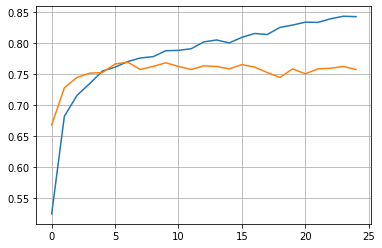

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()

train_eval_result = model.evaluate(train_X_tr, train_y_tr)
validation_eval_result = model.evaluate(val_X, val_y)

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

Try the same model but we will put embeddings straight as an input

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_use_train_X_y(train_df, issue_idx_by_bert[:2500])

train_y_zidx = np.array(labels_to_zeroidx(train_y))

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
train_X_tr, val_X, train_y_tr, val_y = train_test_split(train_X, train_y_zidx, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(512),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5, activation="softmax"),
    ])

  def call(self, inputs):
    embedding = inputs
    return self.sequential(embedding)

# Model from submission_15_1

In [ ]:
model = MyModel()
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=train_X_tr, y=train_y_tr,
          validation_data=(val_X, val_y),
          epochs = 25)

Epoch 1/25
286/286 [==============================] - 7s 14ms/step - loss: 1.2284 - accuracy: 0.5546 - val_loss: 1.2760 - val_accuracy: 0.5433
Epoch 2/25
286/286 [==============================] - 2s 9ms/step - loss: 0.8404 - accuracy: 0.6887 - val_loss: 0.7085 - val_accuracy: 0.7343
Epoch 3/25
286/286 [==============================] - 2s 8ms/step - loss: 0.7628 - accuracy: 0.7220 - val_loss: 0.6509 - val_accuracy: 0.7530
Epoch 4/25
286/286 [==============================] - 2s 8ms/step - loss: 0.6939 - accuracy: 0.7439 - val_loss: 0.6211 - val_accuracy: 0.7431
Epoch 5/25
286/286 [==============================] - 2s 8ms/step - loss: 0.6640 - accuracy: 0.7486 - val_loss: 0.6166 - val_accuracy: 0.7470
Epoch 6/25
286/286 [==============================] - 3s 10ms/step - loss: 0.6325 - accuracy: 0.7641 - val_loss: 0.6158 - val_accuracy: 0.7638
Epoch 7/25
286/286 [==============================] - 4s 13ms/step - loss: 0.6020 - accuracy: 0.7759 - val_loss: 0.6121 - val_accuracy: 0.7608
Epo

In [ ]:
# Test data preparation
test_X = embed(test_data['review_text']).numpy()

model.fit(x=train_X, y=train_y_zidx, epochs=6)
test_pred = model.predict(test_X)

# Make Submisson 15 (embeddings inside)
# val_result = 0.7667
# public    =  0.82000
--------
# Make Submisson 15_1(embeddings outside)
# val_result = 0.7638
# public    =  0.77333

Epoch 1/6
318/318 [==============================] - 7s 17ms/step - loss: 1.2401 - accuracy: 0.5342
Epoch 2/6
318/318 [==============================] - 5s 17ms/step - loss: 0.8334 - accuracy: 0.6881
Epoch 3/6
318/318 [==============================] - 4s 13ms/step - loss: 0.7498 - accuracy: 0.7217
Epoch 4/6
318/318 [==============================] - 5s 15ms/step - loss: 0.7029 - accuracy: 0.7354
Epoch 5/6
318/318 [==============================] - 7s 21ms/step - loss: 0.6696 - accuracy: 0.7460
Epoch 6/6
16/16 [==============================] - 0s 5ms/step


## USE_LARGE (good for linear models)

### USE_LARGE Embeddings + BestSGDClassifier + CleanlabLabels(model=BERT)[:2500]

In [ ]:
# Prepare test data
test_X = embed_large(test_data['review_text']).numpy()

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
cv_score = cross_val_score(classifier, train_X, train_y, cv=10)
print("Accuracy of BestSGDClassifier on USE_Large embds (10-fold cv):", cv_score.mean())

Accuracy of BestSGDClassifier on USE_Large embds (10-fold cv): 0.7940382452193476


In [ ]:
cv_score = cross_val_score(classifier, train_X, train_y, cv=10)
print("Accuracy of BestSGDClassifier on USE_Large embds (10-fold cv):", cv_score.mean())

In [ ]:
classifier.fit(train_X, train_y)
test_pred = classifier.predict(test_X)
# Make submission_17
# 10-fold-cv = 0.79403
# public    =  0.84000

### USE_LARGE Embeddings + MEAN(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

Here we will try to find mean between BERT and BestSGDClassifier predictions.

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])

# Prepare test data
test_X = embed_large(test_data['review_text']).numpy()

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
classifier.fit(train_X, train_y)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
# Make predictions by BERT on test
tokenizer, model = load_bert(output_hidden_states=True)

inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_logits_bert = np.array(lst)

# Logits by BestSGDClassifier
pred_logits_sgdclf = classifier.decision_function(test_X)

In [ ]:
# Find mean prediction and get label
mean_total_pred = np.argmax(((pred_logits_bert + pred_logits_sgdclf) / 2), axis=1) + 1

# Make Submission_18
# public    = 0.87333

### USE_LARGE Embeddings + WEIGHTED_MEAN(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

Here we will try to find mean between BERT and BestSGDClassifier predictions.

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Train and test data.
with tf.device('/device:GPU:0'):
    train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])
    test_X = embed_large(test_data['review_text']).numpy()

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
classifier.fit(train_X, train_y)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
# Make predictions by BERT on test
tokenizer, model = load_bert(output_hidden_states=True)

inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_logits_bert = np.array(lst)

# Logits by BestSGDClassifier
pred_logits_sgdclf = classifier.decision_function(test_X)

In [ ]:
for i in range(11):
    bert_weight  = i * 0.1
    clf_weight = 1 - bert_weight

    sum_pred = np.argmax((bert_weight*pred_logits_bert + clf_weight*pred_logits_sgdclf), axis=1) + 1
    pd.Series(sum_pred, name='label').to_csv(f'{PATH}/Submissions/submission_25_{bert_weight}-and-{clf_weight}.csv', index=False)

# submission_25_0.0-and-1.0 - 0.84000 (only BestSGDClassifier)
# submission_25_0.1-and-0.9 - 0.84667
# submission_25_0.2-and-0.8 - 0.85333
# submission_25_0.3-and-0.7 - 0.85333
## submission_25_0.4-and-0.6 - 0.86667
### submission_25_0.5-and-0.5 - 0.87333
## submission_25_0.6-and-0.4 - 0.86000
# submission_25_0.7-and-0.3 - 0.84667
# submission_25_0.8-and-0.2 - 0.84667
# submission_25_0.9-and-0.1 - 0.83333
# submission_25_1.0-and-0.0 - 0.81333 (only BERT)

### USE_LARGE Embeddings + SGDClassifier_GCV + CleanlabLabels(model=BERT)[:2500]

Here we will try to find best hyperparameters for SGDClassifier.

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])

# Test data
test_X = embed_large(test_data['review_text']).numpy()

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Without GridSearch
print("SGDClassifier_default on large embeddings (10-fold cv):", cross_val_score(SGDClassifier(random_state=RANDOM_SEED), train_X, train_y, cv=10).mean())

SGDClassifier_default on large embeddings (10-fold cv): 0.7851688483675445


Accuracy of default model on large embeddings is higher then accuracy of default model fitted on ordinal embeddings.

In [ ]:
# First GridSearch

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True, n_jobs=-1)

param_grid = {
    "loss": ["hinge", "log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 1, 10, 100], 
    "l1_ratio": [0.2, 0.5, 0.8],
    "class_weight": [None, "balanced"]
}

gcv5 = GridSearchCV(classifier, param_grid, scoring="accuracy", n_jobs=-1)

gcv5.fit(train_X, train_y)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, n_jobs=-1,
                                     penalty='elasticnet', random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0.2, 0.5, 0.8],
                         'loss': ['hinge', 'log_loss', 'perceptron']},
             scoring='accuracy')

In [ ]:
print("Best params", gcv5.best_params_)
print("Best score", gcv5.best_score_)
print("Std", pd.DataFrame(gcv5.cv_results_) .loc[gcv5.best_index_, :].std_test_score)

save_to_pkl(gcv5, "gcv5.pkl")

Best params {'alpha': 0.0001, 'class_weight': 'balanced', 'l1_ratio': 0.2, 'loss': 'log_loss'}
Best score 0.7886181914318215
Std 0.023937773761703245
Successfully safed to gcv5.pkl


In [ ]:
test_preds = gcv5.predict(test_X)
# Make submisson 19
# 5-fold-cv = 0.78861
# public    = 0.80667

And now lets try to find best hyperparameters on the full dataset and only then fit final model on the clean dataset.

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Trainand test data data.
with tf.device('/device:GPU:0'):
    train_X, train_y = get_uselarge_train_X_y(train_df, [])
    train_X_clean, train_y_clean = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])
    test_X = embed_large(test_data['review_text']).numpy()

train_X.shape, train_y.shape

((12652, 512), (12652,))

In [ ]:
# Without GridSearch
print("SGDClassifier_default on large embeddings (10-fold cv):", cross_val_score(SGDClassifier(random_state=RANDOM_SEED), train_X, train_y, cv=10).mean())

SGDClassifier_default on large embeddings (10-fold cv): 0.6670157790557543


In [ ]:
# First GridSearch

classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True, n_jobs=-1)

param_grid = {
    "loss": ["hinge", "log_loss", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 1, 10, 100], 
    "l1_ratio": [0.2, 0.5, 0.8],
    "class_weight": [None, "balanced"]
}

gcv6 = GridSearchCV(classifier, param_grid, scoring="accuracy", n_jobs=-1)

gcv6.fit(train_X, train_y)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, n_jobs=-1,
                                     penalty='elasticnet', random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0.2, 0.5, 0.8],
                         'loss': ['hinge', 'log_loss', 'perceptron']},
             scoring='accuracy')

In [ ]:
print("Best params", gcv6.best_params_)
print("Best score", gcv6.best_score_)
print("Std", pd.DataFrame(gcv6.cv_results_) .loc[gcv6.best_index_, :].std_test_score)

save_to_pkl(gcv6, "gcv6.pkl")

Best params {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.5, 'loss': 'log_loss'}
Best score 0.6722302890794465
Std 0.029211424874064074
Successfully safed to gcv6.pkl


In [ ]:
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True, n_jobs=-1)
classifier.set_params(**gcv6.best_params_)

# Training data.
with tf.device('/device:GPU:0'):
    train_X_clean, train_y_clean = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])

classifier.fit(train_X_clean, train_y_clean)
test_preds = classifier.predict(test_X)

# Make submisson 23
# 5-fold-cv-on-dirty  = 0.67223
# 10-fold-cv-on-clean = 0.79167
# public              = 0.84000

In [ ]:
print("SGDClassifier on large embeddings (10-fold cv):", cross_val_score(classifier, train_X_clean, train_y_clean, cv=10).mean())

SGDClassifier on large embeddings (10-fold cv): 0.7916738101702805


Here we got almost same hyperparameters (excluding l1_ratio) and got same result on public leaderboard as we had with BestSGDClassifier



### USE_LARGE Embeddings + KNN + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Train and test data.
with tf.device('/device:GPU:0'):
    train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])
    test_X = embed_large(test_data['review_text']).numpy()


train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Without GridSearch
print("KNN_default on large embeddings (10-fold cv):", cross_val_score(KNeighborsClassifier(n_jobs=-1), train_X, train_y, cv=10, n_jobs=-1).mean())

KNN_default on large embeddings (10-fold cv): 0.7160209068693999


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(train_X, train_y)
test_preds = knn.predict(test_X)

# Make submisson 24
# 10-fold-cv = 0.71602
# public    =  0.75333

## USE_CMLM (good for nn)

### USE_CMLM Embeddings + BestSGDClassifier + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
train_X, train_y = get_usecmlm_train_X_y(train_df, issue_idx_by_bert[:2500])

# Prepare test data
test_X = embed_bert(test_data['review_text'])

train_X.shape, train_y.shape, test_X.shape

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

((10152, 1024), (10152,), (500, 1024))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
cv_score = cross_val_score(classifier, train_X, train_y, cv=10)
print("Accuracy of BestSGDClassifier on USE_CMLM embds (10-fold cv):", cv_score.mean())

Accuracy of BestSGDClassifier on USE_CMLM embds (10-fold cv): 0.786840308754509


In [ ]:
classifier.fit(train_X, train_y)
test_pred = classifier.predict(test_X)
# Make submission_20

In [ ]:
pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_20.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_20.csv')

# 10-fold-cv = 0.78684
# public     = 0.74000

### USE_CMLM Embeddings + NN + CleanlabLabels(model=BERT)[:2500]

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Training data.
# train_X = load_from_pkl('train_X_use_cmlm.pkl')
# train_y = train_df['label'].drop(issue_idx_by_bert[:2500])

train_X, train_y = get_usecmlm_train_X_y(train_df, issue_idx_by_bert[:2500])
train_y_zidx = np.array(labels_to_zeroidx(train_y))


# Prepare test data
# test_X = embed_bert(test_data['review_text'])
test_X = load_from_pkl('test_X_use_cmlm.pkl')

train_X.shape, train_y.shape, test_X.shape

((10152, 1024), (10152,), (500, 1024))

In [ ]:
train_X_tr, val_X, train_y_tr, val_y = train_test_split(train_X, train_y_zidx, stratify=train_y_zidx, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
class MyModel_NN_1(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(1024),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5, activation="softmax"),
    ])

  def call(self, inputs):
    embedding = inputs
    return self.sequential(embedding)

# Model from submission_21

In [ ]:
with tf.device('/device:GPU:0'):
    model = MyModel_NN_1()
    model.compile(
        loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=train_X_tr, y=train_y_tr,
          validation_data=(val_X, val_y),
          epochs = 25)

Epoch 1/25
286/286 [==============================] - 9s 12ms/step - loss: 0.9811 - accuracy: 0.6614 - val_loss: 0.5473 - val_accuracy: 0.7963
Epoch 2/25
286/286 [==============================] - 2s 9ms/step - loss: 0.6065 - accuracy: 0.7781 - val_loss: 0.5326 - val_accuracy: 0.7972
Epoch 3/25
286/286 [==============================] - 1s 5ms/step - loss: 0.5302 - accuracy: 0.8076 - val_loss: 0.4895 - val_accuracy: 0.8199
Epoch 4/25
286/286 [==============================] - 2s 6ms/step - loss: 0.4843 - accuracy: 0.8176 - val_loss: 0.4781 - val_accuracy: 0.8012
Epoch 5/25
286/286 [==============================] - 1s 5ms/step - loss: 0.4310 - accuracy: 0.8389 - val_loss: 0.4592 - val_accuracy: 0.8100
Epoch 6/25
286/286 [==============================] - 2s 5ms/step - loss: 0.4171 - accuracy: 0.8434 - val_loss: 0.4828 - val_accuracy: 0.8150
Epoch 7/25
286/286 [==============================] - 2s 5ms/step - loss: 0.3817 - accuracy: 0.8576 - val_loss: 0.4958 - val_accuracy: 0.8061
Epoch

32/32 [==============================] - 0s 5ms/step - loss: 0.5593 - accuracy: 0.8199
Training set accuracy: 0.9846760034561157
Validation set accuracy: 0.8198819160461426


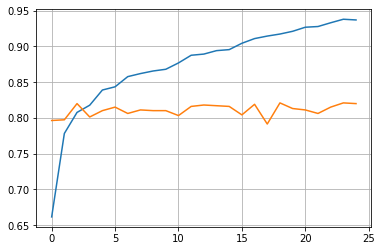

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()

train_eval_result = model.evaluate(train_X_tr, train_y_tr)
validation_eval_result = model.evaluate(val_X, val_y)

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

In [ ]:
acc_per_fold, loss_per_fold = cross_validate_nn(MyModel_NN_1, train_X, train_y_zidx, 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
286/286 [==============================] - 13s 37ms/step - loss: 0.9449 - accuracy: 0.6690 - val_loss: 0.5523 - val_accuracy: 0.7864
Epoch 2/5
286/286 [==============================] - 10s 37ms/step - loss: 0.6060 - accuracy: 0.7796 - val_loss: 0.5227 - val_accuracy: 0.7963
Epoch 3/5
286/286 [==============================] - 10s 33ms/step - loss: 0.5083 - accuracy: 0.8107 - val_loss: 0.5333 - val_accuracy: 0.7953
Epoch 4/5
286/286 [==============================] - 12s 41ms/step - loss: 0.4702 - accuracy: 0.8275 - val_loss: 0.4945 - val_accuracy: 0.8051
Epoch 5/5
286/286 [==============================] - 12s 43ms/step - loss: 0.4265 - accuracy: 0.8356 - val_loss: 0.4893 - val_accuracy: 0.8031
Score for fold 1: loss of 0.489315390586853; accuracy of 80.31495809555054%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
286/2

In [ ]:
print("Accuracy of NN_1 10-fold cv:", np.mean(acc_per_fold))
print("Std of NN_1 10-fold cv:", np.std(acc_per_fold))

Accuracy of NN_1 10-fold cv: 0.8186581194400787
Std of NN_1 10-fold cv: 0.009315440150919447


In [ ]:
model.fit(x=train_X, y=train_y_zidx, epochs=5)
test_preds = model.predict(test_X)

# Make submisson 21

Epoch 1/5
318/318 [==============================] - 7s 7ms/step - loss: 0.9089 - accuracy: 0.6821
Epoch 2/5
318/318 [==============================] - 2s 7ms/step - loss: 0.5802 - accuracy: 0.7884
Epoch 3/5
318/318 [==============================] - 2s 7ms/step - loss: 0.5121 - accuracy: 0.8116
Epoch 4/5
318/318 [==============================] - 3s 9ms/step - loss: 0.4735 - accuracy: 0.8189
Epoch 5/5
16/16 [==============================] - 0s 3ms/step


In [ ]:
# Save the entire model as a SavedModel.
# model.save(f'{PATH}/Saved_model/nn_1')
# model = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_1')

Change layers a bit.  
**Model_NN_2**

In [ ]:
class MyModel_NN_2(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.sequential = tf.keras.Sequential([
      tf.keras.Input(shape=(1024,)),
      tf.keras.layers.Dense(512),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(256),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5, activation="softmax"),
    ])

  def call(self, inputs):
    embedding = inputs
    return self.sequential(embedding)

# Model from submissiom 26_1

In [ ]:
with tf.device('/device:GPU:0'):
    model = MyModel_NN_2()
    model.compile(
        loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=train_X_tr, y=train_y_tr,
          validation_data=(val_X, val_y),
          epochs = 25)

Epoch 1/25
286/286 [==============================] - 7s 16ms/step - loss: 0.9765 - accuracy: 0.6299 - val_loss: 0.5463 - val_accuracy: 0.7972
Epoch 2/25
286/286 [==============================] - 3s 11ms/step - loss: 0.6250 - accuracy: 0.7651 - val_loss: 0.4758 - val_accuracy: 0.8150
Epoch 3/25
286/286 [==============================] - 3s 10ms/step - loss: 0.5284 - accuracy: 0.7965 - val_loss: 0.4483 - val_accuracy: 0.8337
Epoch 4/25
286/286 [==============================] - 3s 10ms/step - loss: 0.4788 - accuracy: 0.8162 - val_loss: 0.4291 - val_accuracy: 0.8366
Epoch 5/25
286/286 [==============================] - 4s 13ms/step - loss: 0.4366 - accuracy: 0.8335 - val_loss: 0.4266 - val_accuracy: 0.8396
Epoch 6/25
286/286 [==============================] - 3s 10ms/step - loss: 0.4069 - accuracy: 0.8446 - val_loss: 0.4203 - val_accuracy: 0.8287
Epoch 7/25
286/286 [==============================] - 3s 10ms/step - loss: 0.3828 - accuracy: 0.8520 - val_loss: 0.4199 - val_accuracy: 0.8366

32/32 [==============================] - 0s 7ms/step - loss: 0.5307 - accuracy: 0.8199
Training set accuracy: 0.9974824786186218
Validation set accuracy: 0.8198819160461426


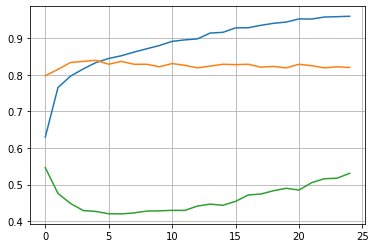

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.grid()

train_eval_result = model.evaluate(train_X_tr, train_y_tr)
validation_eval_result = model.evaluate(val_X, val_y)

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

In [ ]:
acc_per_fold, loss_per_fold = cross_validate_nn(MyModel_NN_2, train_X, train_y_zidx, 7)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/7
286/286 [==============================] - 9s 14ms/step - loss: 0.9719 - accuracy: 0.6320 - val_loss: 0.5810 - val_accuracy: 0.7844
Epoch 2/7
286/286 [==============================] - 5s 16ms/step - loss: 0.6117 - accuracy: 0.7700 - val_loss: 0.5148 - val_accuracy: 0.8091
Epoch 3/7
286/286 [==============================] - 5s 16ms/step - loss: 0.5223 - accuracy: 0.8058 - val_loss: 0.4931 - val_accuracy: 0.8169
Epoch 4/7
286/286 [==============================] - 3s 10ms/step - loss: 0.4678 - accuracy: 0.8242 - val_loss: 0.4754 - val_accuracy: 0.8189
Epoch 5/7
286/286 [==============================] - 3s 10ms/step - loss: 0.4357 - accuracy: 0.8382 - val_loss: 0.4729 - val_accuracy: 0.8199
Epoch 6/7
286/286 [==============================] - 3s 9ms/step - loss: 0.4121 - accuracy: 0.8461 - val_loss: 0.4680 - val_accuracy: 0.8238
Epoch 7/7
286/286 [==============================] -

In [ ]:
print("Accuracy of NN_2 10-fold cv:", np.mean(acc_per_fold))
print("Std of NN_2 10-fold cv:", np.std(acc_per_fold))

Accuracy of NN_2 10-fold cv: 0.8238768875598907
Std of NN_2 10-fold cv: 0.009901433600380656


In [ ]:
model.fit(x=train_X, y=train_y_zidx, epochs=7)
test_preds = model.predict(test_X)

# Make submisson 26 (0.79333) and 26_1 (0.81333)

Epoch 1/7
318/318 [==============================] - 4s 10ms/step - loss: 0.9239 - accuracy: 0.6507
Epoch 2/7
318/318 [==============================] - 4s 13ms/step - loss: 0.5968 - accuracy: 0.7755
Epoch 3/7
318/318 [==============================] - 4s 12ms/step - loss: 0.5126 - accuracy: 0.8062
Epoch 4/7
318/318 [==============================] - 3s 9ms/step - loss: 0.4717 - accuracy: 0.8180
Epoch 5/7
318/318 [==============================] - 3s 9ms/step - loss: 0.4273 - accuracy: 0.8326
Epoch 6/7
318/318 [==============================] - 3s 11ms/step - loss: 0.4044 - accuracy: 0.8438
Epoch 7/7
16/16 [==============================] - 0s 3ms/step


In [ ]:
# Save the entire model as a SavedModel.
# model.save(f'{PATH}/Saved_model/nn_2_1')
# model = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_2')

Now lets try to create model like NN_1 but with some differences.  
**Model_NN_3**

In [ ]:
class MyModel_NN_3(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.sequential = tf.keras.Sequential([
      tf.keras.Input(shape=(1024,)),
      tf.keras.layers.Dense(1024),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(512),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(256),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    embedding = inputs
    return self.sequential(embedding)

# Model from submisson 27_1

In [ ]:
with tf.device('/device:GPU:0'):
    model = MyModel_NN_3()
    model.compile(
        loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=train_X_tr, y=train_y_tr,
          validation_data=(val_X, val_y),
          epochs = 25)

Epoch 1/25
286/286 [==============================] - 15s 39ms/step - loss: 1.0041 - accuracy: 0.6248 - val_loss: 0.5341 - val_accuracy: 0.8130
Epoch 2/25
286/286 [==============================] - 11s 37ms/step - loss: 0.6259 - accuracy: 0.7625 - val_loss: 0.4614 - val_accuracy: 0.8219
Epoch 3/25
286/286 [==============================] - 10s 33ms/step - loss: 0.5356 - accuracy: 0.7983 - val_loss: 0.4425 - val_accuracy: 0.8209
Epoch 4/25
286/286 [==============================] - 9s 30ms/step - loss: 0.4743 - accuracy: 0.8213 - val_loss: 0.4312 - val_accuracy: 0.8258
Epoch 5/25
286/286 [==============================] - 9s 33ms/step - loss: 0.4529 - accuracy: 0.8219 - val_loss: 0.4311 - val_accuracy: 0.8199
Epoch 6/25
286/286 [==============================] - 8s 27ms/step - loss: 0.4055 - accuracy: 0.8496 - val_loss: 0.4339 - val_accuracy: 0.8287
Epoch 7/25
286/286 [==============================] - 9s 32ms/step - loss: 0.3776 - accuracy: 0.8562 - val_loss: 0.4348 - val_accuracy: 0.8

32/32 [==============================] - 0s 6ms/step - loss: 0.6534 - accuracy: 0.8179
Training set accuracy: 0.9985770583152771
Validation set accuracy: 0.8179134130477905


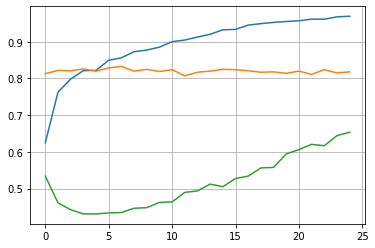

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.grid()

train_eval_result = model.evaluate(train_X_tr, train_y_tr)
validation_eval_result = model.evaluate(val_X, val_y)

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

In [ ]:
acc_per_fold, loss_per_fold = cross_validate_nn(MyModel_NN_3, train_X, train_y_zidx, 4, True)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/4
286/286 [==============================] - 12s 35ms/step - loss: 0.9920 - accuracy: 0.6324 - val_loss: 0.5753 - val_accuracy: 0.7805
Epoch 2/4
286/286 [==============================] - 6s 21ms/step - loss: 0.6262 - accuracy: 0.7627 - val_loss: 0.5081 - val_accuracy: 0.7982
Epoch 3/4
286/286 [==============================] - 6s 20ms/step - loss: 0.5196 - accuracy: 0.8016 - val_loss: 0.4839 - val_accuracy: 0.8091
Epoch 4/4
286/286 [==============================] - 7s 24ms/step - loss: 0.4742 - accuracy: 0.8206 - val_loss: 0.4701 - val_accuracy: 0.8140
Score for fold 1: loss of 0.47007715702056885; accuracy of 81.39764070510864%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/4
286/286 [==============================] - 7s 20ms/step - loss: 0.9450 - accuracy: 0.6438 - val_loss: 0.5496 - val_accuracy: 0.7904
Epoch 2/4
286/286

In [ ]:
print("Accuracy of NN_3 10-fold cv:", np.mean(acc_per_fold))
print("Std of NN_3 10-fold cv:", np.std(acc_per_fold))

Accuracy of NN_3 10-fold cv: 0.8226976215839386
Std of NN_3 10-fold cv: 0.011730729083802767


In [ ]:
model.fit(x=train_X, y=train_y_zidx, epochs=5)
test_preds = model.predict(test_X)

# Make submisson 27 and 27_1
# 10-fold cv (4 epoch)  = 0.82269
# public (4 epoch)      = 0.79333 # sumbission 27
# public (5 epoch) = 0.83333 # sumbission 27_1 / nn_3

Epoch 1/5
318/318 [==============================] - 13s 32ms/step - loss: 0.9689 - accuracy: 0.6283
Epoch 2/5
318/318 [==============================] - 9s 28ms/step - loss: 0.6105 - accuracy: 0.7669
Epoch 3/5
318/318 [==============================] - 11s 33ms/step - loss: 0.5197 - accuracy: 0.8015
Epoch 4/5
318/318 [==============================] - 8s 27ms/step - loss: 0.4766 - accuracy: 0.8151
Epoch 5/5
16/16 [==============================] - 0s 5ms/step


In [ ]:
# Save the entire model as a SavedModel.
# model.save(f'{PATH}/Saved_model/nn_3')
# model = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_3')

### MEAN([USE/BestSGDClassifier] & [BERT] &  [USE_CMLM/NN_1/NN_3])) + CleanlabLabels(model=BERT)[:2500]

Here we will try to find mean between BERT, BestSGDClassifier and NN_1 predictions.

In [ ]:
# Make predictions from nn_1 (on use_cmlm 1024 embeddings)
test_X_use_cmlm = embed_bert(test_data['review_text'])

nn_1 = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_1')
nn_1_test_preds = nn_1.predict(test_X_use_cmlm)

nn_3 = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_3')
nn_3_test_preds = nn_3.predict(test_X_use_cmlm)

In [ ]:
# save_to_pkl(nn_3_test_preds, 'nn_3_test_preds.pkl')
# save_to_pkl(pred_logits_bert, 'bert_pretrained_test_preds.pkl')
# save_to_pkl(pred_logits_sgdclf, 'bestsgdclf_test_preds.pkl')


nn_3_test_preds = load_from_pkl('nn_3_test_preds.pkl')
pred_logits_bert = load_from_pkl('bert_pretrained_test_preds.pkl')
pred_logits_sgdclf = load_from_pkl('bestsgdclf_test_preds.pkl')

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Prepare train and test data for BestSGDClf
with tf.device('/device:GPU:0'):
    train_X, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])
    test_X = embed_large(test_data['review_text']).numpy()

train_X.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

# Fit classifier
classifier.fit(train_X, train_y)

SGDClassifier(early_stopping=True, l1_ratio=0.2, loss='log_loss',
              penalty='elasticnet', random_state=0)

In [ ]:
# Make predictions by BERT on test
tokenizer, model = load_bert(output_hidden_states=True)

inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_logits_bert = np.array(lst)

# Logits by BestSGDClassifier
pred_logits_sgdclf = classifier.decision_function(test_X)

In [ ]:
# Find mean prediction and get labels
mean_total_pred = np.argmax(((pred_logits_bert + pred_logits_sgdclf + nn_1_test_preds) / 3), axis=1) + 1
mean_total_pred_1 = np.argmax(((pred_logits_sgdclf + nn_1_test_preds) / 2), axis=1) + 1

# Make Submission_22 and Submission_22_1

In [ ]:
# Find mean prediction and get labels (by logits)
mean_total_pred = np.argmax(((pred_logits_bert + pred_logits_sgdclf + nn_3_test_preds) / 3), axis=1) + 1 # Submission_28 (0.86000)
mean_total_pred_1 = np.argmax(((pred_logits_sgdclf + nn_3_test_preds) / 2), axis=1) + 1 # Submission_28_1 (0.84667)
mean_total_pred_2 = np.argmax(((nn_3_test_preds + pred_logits_bert) / 2), axis=1) + 1 # Submission_28_4 (0.83333)

In [ ]:
# Find mean prediction and get labels (by softmax probabilities)
mean_total_pred = np.argmax(((tf.nn.softmax(pred_logits_bert).numpy() + 
                              tf.nn.softmax(pred_logits_sgdclf).numpy() +             
                              tf.nn.softmax(nn_3_test_preds).numpy()) / 3), axis=1) + 1  # Submission_28_2 (0.86000)
mean_total_pred_1 = np.argmax(((tf.nn.softmax(pred_logits_sgdclf).numpy() + 
                                tf.nn.softmax(nn_3_test_preds).numpy()) / 2), axis=1) + 1 # Submission_28_3 (0.86000)
mean_total_pred_2 = np.argmax(((tf.nn.softmax(nn_3_test_preds).numpy() + 
                                tf.nn.softmax(pred_logits_bert).numpy()) / 2), axis=1) + 1 # Submission_28_5 (0.84000)

Lets take a look at the distribution of predictions of different models

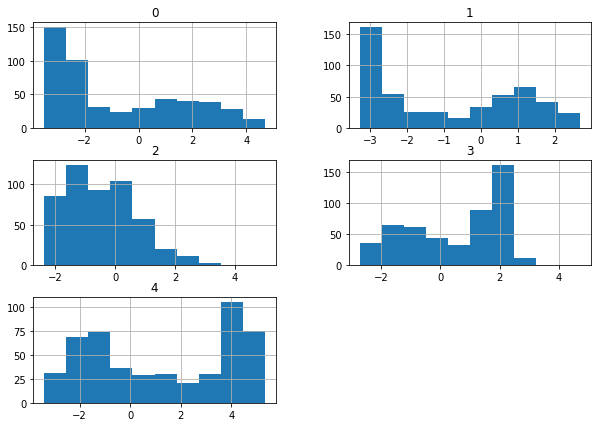

In [ ]:
pd.DataFrame(pred_logits_bert).hist(figsize=(10, 7));
plt.title('Distribution of BERT predicted logits');

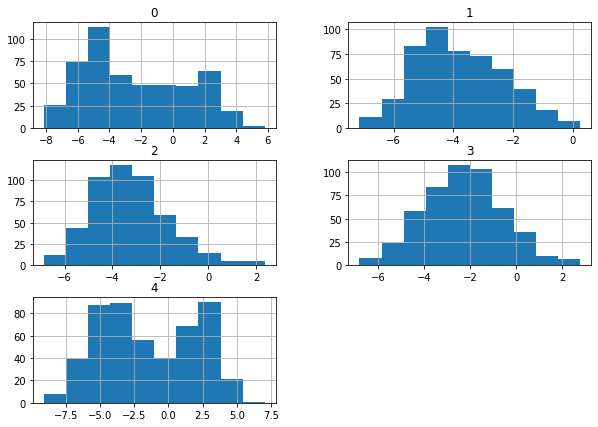

In [ ]:
pd.DataFrame(pred_logits_sgdclf).hist(figsize=(10, 7));
plt.title('Distribution of SGDClf predicted logits');

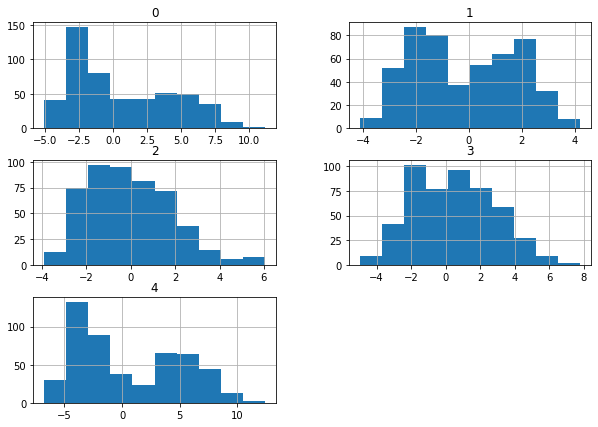

In [ ]:
pd.DataFrame(nn_3_test_preds).hist(figsize=(10, 7));
plt.title('Distribution of NN_3 predicted logits');

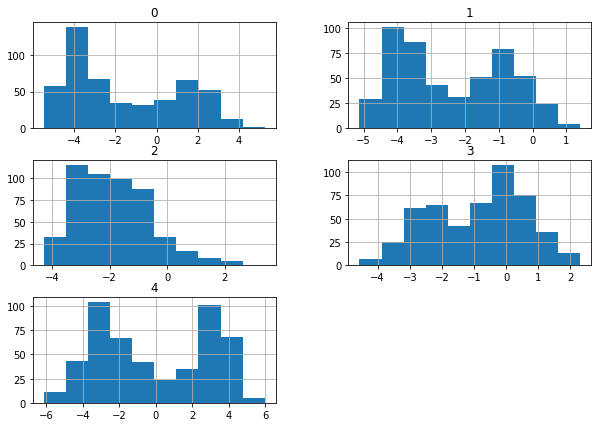

In [ ]:
pd.DataFrame((pred_logits_sgdclf + pred_logits_bert) / 2).hist(figsize=(10, 7));
plt.title('Distribution of MEAN(BERT+SGDClf) predicted logits');

# Pretrained BERT model

In [ ]:
tokenizer, model = load_bert(output_hidden_states=True)

inputs = train_df['review_text'][:5].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    # logits = inputs.apply(lambda x: model(**x).logits)
    output = inputs.apply(lambda x: model(**x))


pred_labels = logits.apply(lambda x: torch.nn.Softmax()(x).numpy().argmax() + 1)

<ipython-input-98-a6316530572c>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_labels = logits.apply(lambda x: torch.nn.Softmax()(x).numpy().argmax() + 1)


In [ ]:
# Train accuracy score
accuracy_score(train_y, pred_labels)

0.6169775529560544

In [ ]:
output[0].hidden_states[0].shape

torch.Size([1, 27, 768])

In [ ]:
last_hidden_state = output[0].hidden_states[0]
cls_embeddings = last_hidden_state[:, 0]

cls_embeddings.shape

torch.Size([1, 768])

# Final Models

### Best submissions quick review

In [ ]:
### TOP 2 ###
# USE_LARGE Embeddings + BestSGDClassifier + CleanlabLabels(model=BERT)[:2500]
pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_17.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_17.csv')

# 10-fold-cv = 0.79403
# public    =  0.84000

In [ ]:
### TOP 1 ###
# USE_LARGE Embeddings + MEAN_LOGITS(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_18.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_18.csv')

# public    = 0.87333

In [ ]:
### BEST ###
# USE_CMLM Embeddings + NN_3 + CleanlabLabels(model=BERT)[:2500]
pd.Series(np.argmax(test_preds, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_27_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_27_1.csv')

# 10-fold cv (4 epoch)  = 0.82269
# public (4 epoch)      = 0.79333 # sumbission 27
# public (5 epoch) = 0.83333 # sumbission 27_1 / nn_3

### BERT_Pretrained

In [ ]:
# Make predictions by BERT on test
tokenizer, model = load_bert(output_hidden_states=True)

inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]
pred_logits_bert = np.array(lst)

# Logits by BestSGDClassifier
pred_logits_sgdclf = classifier.decision_function(test_X)

### BestSGDClassifier

In [ ]:
issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

# Prepare train and test data
with tf.device('/device:GPU:0'):
    train_X_use_large, train_y = get_uselarge_train_X_y(train_df, issue_idx_by_bert[:2500])
    test_X_use_large = embed_large(test_data['review_text']).numpy()

train_X_use_large.shape, train_y.shape

((10152, 512), (10152,))

In [ ]:
# Initialize best SGDClasssifer
best_params = {'alpha': 0.0001, 'class_weight': None, 'l1_ratio': 0.2, 'loss': 'log_loss'}
classifier = SGDClassifier(penalty="elasticnet", random_state=RANDOM_SEED, early_stopping=True)
classifier.set_params(**best_params)

# Fit classifier and save for futher using
classifier.fit(train_X_use_large, train_y)
save_to_pkl(classifier, 'Saved_model/bestsgdclf_final.pkl')

Successfully safed to Saved_model/bestsgdclf_final.pkl


### NN_3

In [ ]:
# nn_3 = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_3')

In [ ]:
# Training data.
# data_clean = train_df['review_text'].drop(issue_idx_by_bert[:2500])
# train_X = embed_bert(data_clean)

issue_idx_by_bert = load_from_pkl("issue_idx_by_bert.pkl")

train_X_use_cmlm = load_from_pkl('train_X_use_cmlm.pkl')
train_y = train_df['label'].drop(issue_idx_by_bert[:2500])
train_y_zidx = np.array(labels_to_zeroidx(train_y))

train_X_use_cmlm.shape, train_y_zidx.shape

((10152, 1024), (10152,))

In [ ]:
class MyModel_NN_3(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.sequential = tf.keras.Sequential([
      tf.keras.Input(shape=(1024,)),
      tf.keras.layers.Dense(1024),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(512),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(256),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(rate=0.3, seed=RANDOM_SEED),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    embedding = inputs
    return self.sequential(embedding)

# Model from submisson 27_1

In [ ]:
with tf.device('/device:GPU:0'):
    model = MyModel_NN_3()
    model.compile(
        loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

### Stacking

In [ ]:
# Making cross validated predictions
nn_3_cv_preds_unsorted, cv_indices = cross_val_predict_nn(MyModel_NN_3, train_X_use_cmlm, train_y_zidx, 5, True)
nn_3_cv_preds = pd.DataFrame(nn_3_cv_preds_unsorted, index=cv_indices).sort_index(ascending=True).values

bestsgdclf_cv_preds = cross_val_predict(classifier, train_X_use_large, train_y, cv=10, n_jobs=-1, method='decision_function')

In [ ]:
# Create new features
new_features = np.column_stack([nn_3_cv_preds, bestsgdclf_cv_preds])
new_features.shape

(10152, 10)

In [ ]:
# Initialize Metamodel_CB  cross_val accuracy check
metamodel = CatBoostClassifier(random_state=RANDOM_SEED)

print("Metamodel Catboost accuracy on 10-fold-cv", cross_val_score(metamodel, new_features, train_y, cv=10, n_jobs=-1).mean())

Metamodel Catboost accuracy on 10-fold-cv 0.8230955936542415


In [ ]:
# Initialize Metamodel_RF cross_val accuracy check
metamodel_rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight="balanced", n_estimators=500, max_features="sqrt")

print("Metamodel Random Forest accuracy on 10-fold-cv", cross_val_score(metamodel_rf, new_features, train_y, cv=10, n_jobs=-1).mean())

Metamodel Catboost accuracy on 10-fold-cv 0.8299919514371048


In [ ]:
# Fit Metamodel RF
metamodel_rf.fit(new_features, train_y)
save_to_pkl(metamodel_rf, f'Saved_model/metamodel_rf_final.pkl')

Successfully safed to Saved_model/metamodel_rf_final.pkl


In [ ]:
# Fit MetaModel_CB on metafeatures
metamodel.fit(new_features, train_y)
# save_to_pkl(metamodel, f'Saved_model/metamodel_cb_final.pkl')

# Load predictions of models on test set
pred_logits_bert = load_from_pkl('bert_pretrained_test_preds.pkl')
nn_3_test_preds = load_from_pkl('nn_3_test_preds.pkl')
pred_logits_sgdclf = load_from_pkl('bestsgdclf_test_preds.pkl')

# Stack together predictions from BestSGDClf and NN_3
new_test_features = np.column_stack([nn_3_test_preds, pred_logits_sgdclf])

# Find test predicted labels and logits of Metamodel on new stacked test features 
test_preds = metamodel.predict(new_test_features).squeeze() # Submission_29 (0.86667)
meta_test_preds_logits = metamodel.predict(new_test_features, prediction_type='RawFormulaVal')

Now lets find mean prediction of Metamodel & BERT

In [ ]:
# Using logits
mean_total_pred = np.argmax(((pred_logits_bert + meta_test_preds_logits) / 2), axis=1) + 1 # Submission 30 BEST (0.88000)

# Using softmax probabilities
mean_total_pred_probs = np.argmax(((tf.nn.softmax(pred_logits_bert).numpy() + 
                                    tf.nn.softmax(meta_test_preds_logits).numpy()) / 2), axis=1) + 1 # Submission 30_1

## Testing and making final submissions

In [ ]:
# Load final test data
final_test_data = pd.read_csv(f'{PATH}/Final_Test_Data/test.csv')

In [ ]:
# Loading NN_3
nn_3 = tf.keras.models.load_model(f'{PATH}/Saved_model/nn_3')

# Loading BestSGDClassifier
classifier = load_from_pkl('Saved_model/bestsgdclf_final.pkl')

# Loading MetaModel Catboost
metamodel_cb = load_from_pkl('Saved_model/metamodel_cb_final.pkl')

# Loading MetaModel RandomForest
metamodel_rf = load_from_pkl('Saved_model/metamodel_rf_final.pkl')

# Prepare test data for NN_3
final_test_X_use_cmlm = embed_bert(final_test_data['review_text'])

# Prepare test data for BestSGDClassifier
with tf.device('/device:GPU:0'):
    final_test_X_use_large = embed_large(final_test_data['review_text']).numpy()

final_test_X_use_cmlm.shape, final_test_X_use_large.shape

  0%|          | 0/11 [00:00<?, ?it/s]

((1000, 1024), (1000, 512))

In [ ]:
# Get MetaModel CB predicted logits
nn_3_pred_logits = nn_3.predict(final_test_X_use_cmlm)
clf_pred_logits = classifier.decision_function(final_test_X_use_large)

meta_features = np.column_stack([nn_3_pred_logits, clf_pred_logits])

metamodel_pred_logits = metamodel_cb.predict(meta_features, prediction_type='RawFormulaVal')

32/32 [==============================] - 0s 2ms/step


In [ ]:
# Save submission Metamodel_CB logits
pd.Series(np.argmax(metamodel_pred_logits, axis=1) + 1, name='label').to_csv(f'{PATH}/Submissions/final_submission_metamodel.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_metamodel.csv')

# 0.78667

In [ ]:
# Get MetaModel_RF predicted logits
metamodel_rf_pred_probs = metamodel_rf.predict_proba(meta_features)

# Save submission Metamodel RF probabilities
pd.Series(np.argmax(metamodel_rf_pred_probs, axis=1) + 1, name='label').to_csv(f'{PATH}/Submissions/final_submission_rf_metamodel.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_rf_metamodel.csv')

# 0.81000

In [ ]:
# Save submission NN_3 logits
pd.Series(np.argmax(nn_3_pred_logits, axis=1) + 1, name='label').to_csv(f'{PATH}/Submissions/final_submission_NN_3.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_NN_3.csv')

# 0.76333

In [ ]:
# Save submission BestSGDClassifier logits
pd.Series(np.argmax(clf_pred_logits, axis=1) + 1, name='label').to_csv(f'{PATH}/Submissions/final_submission_clf.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_clf.csv')

# 0.79333

In [ ]:
# Get BERT predicted logits
tokenizer, model = load_bert(output_hidden_states=True)

inputs = final_test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

# Logits by BERT
pred_logits = logits.apply(lambda x: x.numpy())
vals = pred_logits.apply(lambda x: x[0]).values
lst = [[el[i] for i in range(len(el))] for el in vals]

bert_pred_logits = np.array(lst)

In [ ]:
# Save submission BERT logits
pd.Series(np.argmax(bert_pred_logits, axis=1) + 1, name='label').to_csv(f'{PATH}/Submissions/final_submission_bert.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_bert.csv')

# 0.81333

In [ ]:
# Stack BERT & MetaModel_CB predictions
total_predicted_labels = np.argmax(((bert_pred_logits + metamodel_pred_logits) / 2), axis=1) + 1

# Save submission
pd.Series(total_predicted_labels, name='label').to_csv(f'{PATH}/Submissions/final_submission.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission.csv')

# 0.84000

In [ ]:
# Stack BERT & MetaModel_RF probabilities predictions 
total_predicted_rf_labels = np.argmax((tf.nn.softmax(bert_pred_logits).numpy() + tf.nn.softmax(metamodel_rf_pred_probs).numpy() / 2), axis=1) + 1

# Save submission
pd.Series(total_predicted_rf_labels, name='label').to_csv(f'{PATH}/Submissions/final_submission_rf.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_rf.csv')

# 0.83000

In [ ]:
# Stack BERT & BestSGDClassifier predictions
total_predicted_labels_bert_clf = np.argmax(((bert_pred_logits + clf_pred_logits) / 2), axis=1) + 1

# Save submission
pd.Series(total_predicted_labels_bert_clf, name='label').to_csv(f'{PATH}/Submissions/final_submission_bert_clf.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_bert_clf.csv')

# 0.85333

In [ ]:
# Stack BERT & BestSGDClassifier & Metamodel_CB predictions
total_predicted_labels_bert_clf_meta = np.argmax(((bert_pred_logits + clf_pred_logits + metamodel_pred_logits) / 3), axis=1) + 1

# Save submission
pd.Series(total_predicted_labels_bert_clf_meta, name='label').to_csv(f'{PATH}/Submissions/final_submission_bert_clf_meta.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_bert_clf_meta.csv')

# 0.85333

In [ ]:
# Stack 2хBERT & BestSGDClassifier & Metamodel_CB
total_predicted_labels_bert2_clf_meta = np.argmax(((bert_pred_logits + bert_pred_logits + clf_pred_logits + metamodel_pred_logits) / 4), axis=1) + 1

# Save submission
pd.Series(total_predicted_labels_bert2_clf_meta, name='label').to_csv(f'{PATH}/Submissions/final_submission_bert2_clf_meta.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_bert2_clf_meta.csv')

# 0.86000

In [ ]:
# Stack 3хBERT & BestSGDClassifier & Metamodel_CB
total_predicted_labels_bert3_clf_meta = np.argmax(((bert_pred_logits + bert_pred_logits + bert_pred_logits + clf_pred_logits + metamodel_pred_logits) / 5), axis=1) + 1

# Save submission
pd.Series(total_predicted_labels_bert3_clf_meta, name='label').to_csv(f'{PATH}/Submissions/final_submission_bert3_clf_meta.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/final_submission_bert3_clf_meta.csv')

# 0.87333

# Public submissions

In [ ]:
# WordsOnly + TfIdf + SGDClassifier (gcv1)
test_data['words_only'] = test_data['review_text'].apply(extract_words)
test_preds = gcv1.best_estimator_.predict(test_data['words_only'])
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_1_gcv1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_1_gcv1.csv')

# 5-fold-cv = 0.68511
# public    = 0.75333

In [ ]:
# Lemmas + TfIdf + SGDClassifier (gcv3)
test_data['lemmas'] = test_data['review_text'].apply(lambda x: tokenize_lemmatize(x))
test_preds = gcv3.best_estimator_.predict(test_data['lemmas'])
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_2_gcv3.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_2_gcv3.csv')

# 5-fold-cv = 0.67444
# public    = 0.76667

In [ ]:
### TOP ###
# BERT Pretrained
inputs = test_data['review_text'].apply(lambda x: tokenizer(x, return_tensors="pt"))

with torch.no_grad():
    logits = inputs.apply(lambda x: model(**x).logits)

pred_labels = logits.apply(lambda x: torch.nn.Softmax()(x).numpy().argmax() + 1)

pd.Series(pred_labels.values, name='label').to_csv(f'{PATH}/Submissions/submission_3_bertpretrained.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_3_bertpretrained.csv')

# train_acc = 0.61697
# public    = 0.81333

In [ ]:
# Lemmas + TfIdf + BestSGDClassifier + CleanLabLabels(model=BestSGDClassifier)
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_4.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_4.csv')

# 10-fold-cv = 0.84741
# public    =  0.72667

In [ ]:
# Lemmas + TfIdf + BestSGDClassifier + CleanLabLabels(model=BERT)
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_5.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_5.csv')

# 10-fold-cv = 0.80023
# public    =  0.77333

In [ ]:
# USE Embeddings + LogReg/lbfgs(iter=1000) + CleanLabLabels(model=BERT)
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_6.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_6.csv')

# 10-fold-cv = 0.78235
# public    = 0.77333

# submission_6_drop-500 - 0.76667
# submission_6_drop-1000 - 0.76667
# submission_6_drop-1500 - 0.77333
### submission_6_drop-2000 - 0.78000
# submission_6_drop-2500 - 0.77333
# submission_6 (drop_all) - 0.77333

In [ ]:
### TOP ###
# USE Embeddings + BestSGDClassifier + CleanLabLabels(model=BERT)
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_7.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_7.csv')

# 10-fold-cv = 0.77184
# public     = 0.79333

# submission_7_drop-500 - 0.77333
# submission_7_drop-1000 - 0.78000
# submission_7_drop-1500 - 0.77333
# submission_7_drop-2000 - 0.80667
### TOP ### submission_7_drop-2500 = 0.81333
                      # 10-fold-cv = 0.76271
# submission_7 (drop_all) - 0.79333

In [ ]:
# USE Embeddings + SGDClassifier_GCV4 + CleanlabLabels(model=BERT)[:2500]
test_X = embed(test_data['review_text']).numpy()

test_preds = gcv4.best_estimator_.predict(test_X)
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_8_gcv4.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_8_gcv4.csv')

# 5-fold-cv = 0.75886
# public    = 0.80000

In [ ]:
# USE Embeddings + StratifiedClassifier(5 x BestSGDClassifier) + CleanlabLabels(model=BERT)[:2500]

pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_9.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_9.csv')

# 10-fold-cv = 0.756599
# public    = 0.80667

In [ ]:
# USE Embeddings + OneVsRestClassifier(BestSGDClassifier) + CleanlabLabels(model=BERT)[:2500]

pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_12.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_12.csv')

# 10-fold-cv = 0.75680
# public    = 0.80667

In [ ]:
# USE Embeddings + OneVsOneClassifier(BestSGDClassifier) + CleanlabLabels(model=BERT)[:2500]

pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_13.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_13.csv')

# 10-fold-cv = 0.76675
# public    = 0.76667

In [ ]:
# USE Embeddings + OutputCodeClassifier(BestSGDClassifier) + CleanlabLabels(model=BERT)[:2500]

pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_14.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_14.csv')

# 10-fold-cv = 0.73818
# public    = 0.76667

In [ ]:
# USE Embeddings + StratifiedClassifier(5 x BestSGDClassifier) + MetaModel(BestSGDClassifier)(fited on pred_probs of prev 5 clfs) + CleanlabLabels(model=BERT)[:2500]

pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_10.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_10.csv')

# 10-fold-cv = 0.76231
# public    = 0.81333

In [ ]:
# USE Embeddings + MEAN_PROBS(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_11.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_11.csv')

# public    = 0.82667

In [ ]:
### prev. TOP ###
# USE Embeddings + MEAN_LOGITS(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_16.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_16.csv')

# public    = 0.83333

In [ ]:
# USE Embeddings + 2-layer-NN + CleanlabLabels(model=BERT)[:2500] (embeddings inside)
pd.Series(np.argmax(test_pred, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_15.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_15.csv')

# val_result = 0.7667
# public    =  0.82000
--------
# USE Embeddings + 2-layer-NN + CleanlabLabels(model=BERT)[:2500] (embeddings outside)
pd.Series(np.argmax(test_pred, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_15_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_15_1.csv')

# val_result = 0.7638
# public    =  0.77333

In [ ]:
### TOP 2 ###
# USE_LARGE Embeddings + BestSGDClassifier + CleanlabLabels(model=BERT)[:2500]
pd.Series(test_pred, name='label').to_csv(f'{PATH}/Submissions/submission_17.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_17.csv')

# 10-fold-cv = 0.79403
# public    =  0.84000

In [ ]:
### TOP 1 ###
# USE_LARGE Embeddings + MEAN_LOGITS(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_18.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_18.csv')

# public    = 0.87333

In [ ]:
# USE_LARGE Embeddings + WEIGHTED_LOGITS(BestSGDClassifier & BERT) + CleanlabLabels(model=BERT)[:2500]

# submission_25_0.0-and-1.0 - 0.84000 (only BestSGDClassifier)
# submission_25_0.1-and-0.9 - 0.84667
# submission_25_0.2-and-0.8 - 0.85333
# submission_25_0.3-and-0.7 - 0.85333
## submission_25_0.4-and-0.6 - 0.86667
### submission_25_0.5-and-0.5 - 0.87333
## submission_25_0.6-and-0.4 - 0.86000
# submission_25_0.7-and-0.3 - 0.84667
# submission_25_0.8-and-0.2 - 0.84667
# submission_25_0.9-and-0.1 - 0.83333
# submission_25_1.0-and-0.0 - 0.81333 (only BERT)

In [ ]:
# USE_LARGE Embeddings + SGDClassifier_GCV + CleanlabLabels(model=BERT)[:2500]
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_19.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_19.csv')

# 5-fold-cv = 0.78861
# public    = 0.80667

In [ ]:
### BEST ### 
# USE_CMLM Embeddings + NN_1 + CleanlabLabels(model=BERT)[:2500]
pd.Series(np.argmax(test_preds, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_21.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_21.csv')

# 10-fold cv: 0.81865
# val_result = 0.8100
# public    =  0.83333

In [ ]:
# USE_CMLM Embeddings + NN_2 + CleanlabLabels(model=BERT)[:2500]
pd.Series(np.argmax(test_preds, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_26.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_26.csv')
# 9 epochs

# public    =  0.79333
----------
# USE_CMLM Embeddings + NN_2_1 + CleanlabLabels(model=BERT)[:2500]
pd.Series(np.argmax(test_preds, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_26_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_26_1.csv')
# 7 epochs

# 10-fold cv =  0.82387
# public     =  0.81333

In [ ]:
### BEST ###
# USE_CMLM Embeddings + NN_3 + CleanlabLabels(model=BERT)[:2500]
pd.Series(np.argmax(test_preds, axis=1)+1, name='label').to_csv(f'{PATH}/Submissions/submission_27_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_27_1.csv')

# 10-fold cv (4 epoch)  = 0.82269
# public (4 epoch)      = 0.79333 # sumbission 27
# public (5 epoch) = 0.83333 # sumbission 27_1 / nn_3

In [ ]:
### pre TOP ###
# MEAN([USE_LARGE+BestSGDClassifier] & [BERT] & [USE_CMLM+NN_1probs])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_22.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_22.csv')

# public    = 0.87333

In [ ]:
# MEAN([USE_LARGE+BestSGDClassifier] & [USE_CMLM+NN_1probs])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred_1, name='label').to_csv(f'{PATH}/Submissions/submission_22_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_22_1.csv')

# public    = 0.86000

In [ ]:
### pre TOP ###
# MEAN_LOGITS([USE_LARGE+BestSGDClassifier] & [BERT] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_28.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28.csv')

# public    = 0.86000

In [ ]:
### pre TOP ###
# MEAN_LOGITS([USE_LARGE+BestSGDClassifier] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred_1, name='label').to_csv(f'{PATH}/Submissions/submission_28_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28_1.csv')

# public    = 0.84667

In [ ]:
### pre TOP ###
# MEAN_LOGITS([BERT] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred_2, name='label').to_csv(f'{PATH}/Submissions/submission_28_4.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28_4.csv')

# public    = 0.83333

In [ ]:
# MEAN_PROBS([USE_LARGE+BestSGDClassifier] & [BERT] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_28_2.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28_2.csv')

# public    = 0.86000

In [ ]:
# MEAN_PROBS([USE_LARGE+BestSGDClassifier] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred_1, name='label').to_csv(f'{PATH}/Submissions/submission_28_3.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28_3.csv')

# public    = 0.86000

In [ ]:
# MEAN_PROBS([BERT] & [USE_CMLM+NN_3])) + CleanlabLabels(model=BERT)[:2500]

pd.Series(mean_total_pred_2, name='label').to_csv(f'{PATH}/Submissions/submission_28_5.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_28_5.csv')

# public    = 0.84000

In [ ]:
# USE_LARGE Embeddings + SGDClassifier_GCV_on-dirty-data + CleanlabLabels(model=BERT)[:2500]
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_23.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_23.csv')

# 5-fold-cv-on-dirty  = 0.67223
# 10-fold-cv-on-clean = 0.79167
# public              = 0.84000

In [ ]:
# USE_LARGE Embeddings + KNN + CleanlabLabels(model=BERT)[:2500]
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_24.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_24.csv')

# 10-fold-cv = 0.71602
# public    =  0.75333

In [ ]:
### BEST 1 ###
pd.Series(test_preds, name='label').to_csv(f'{PATH}/Submissions/submission_29.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_29.csv')

# 10-fold-cv = 0.82309
# public    = 0.86667

In [ ]:
### FINAL BEST SOLUTION ###
# MEAN_LOGITS(META_MODEL & BERT)
pd.Series(mean_total_pred, name='label').to_csv(f'{PATH}/Submissions/submission_30.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_30.csv')

# public    = 0.88000

In [ ]:
# MEAN_PROBS(META_MODEL & BERT)
pd.Series(mean_total_pred_probs, name='label').to_csv(f'{PATH}/Submissions/submission_30_1.csv', index=False)
pd.read_csv(f'{PATH}/Submissions/submission_30_1.csv')

# public    = 0.87333